In [1]:
#importo e librerie che mi serviranno
import pymongo
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

URI = "mongodb://127.0.0.1:27017/?readPreference=primary&ssl=false"
client = pymongo.MongoClient(URI)
db = client['movie_dataset']



# Preparazione dei dati

In [5]:
#lista dei film
df_film = pd.DataFrame(db.metadata.find({}, {'_id':1, 'vote_average':1 , 'vote_count':1 }))



In [6]:
df_film.shape

(45433, 3)

In [7]:
#rinomino la colonna _id in movie_id
df_film =  df_film.rename(columns = {'_id' : 'movie_id'})

In [8]:
#Lista crew
#prendo dalla collection crew l' id della persona del film e il ruolo svolto
df_crew = pd.DataFrame(db.crew.find({}, {'person_id':1, 'movie_id':1,'_id':0,'department':1})).astype({'movie_id': 'int32','person_id': 'int32'})

df_crew

,department,person_id,movie_id
0,Directing,7879,862
1,Writing,12891,862
2,Writing,7,862
3,Writing,12892,862
4,Writing,12893,862
...,...,...,...
464309,Sound,549356,67758
464310,Camera,58818,67758
464311,Directing,1085341,227506
464312,Production,1195656,227506


In [9]:
df_crew.dtypes

department    object
person_id      int32
movie_id       int32
dtype: object

In [10]:
#rinomino l' id delle persone da person_id a _id
df_crew =  df_crew.rename(columns = {'person_id' : '_id'})
df_crew.head()


,department,_id,movie_id
0,Directing,7879,862
1,Writing,12891,862
2,Writing,7,862
3,Writing,12892,862
4,Writing,12893,862


In [11]:
#Lista cast
#prendo dalla collection cast l' id della persona del film e come ruolo svolto metto attore, mi servirà quando andrò a fare la concat
df_cast = pd.DataFrame(db.cast.find({}, {'person_id':1, 'movie_id':1,'_id':0})).astype({'movie_id': 'int32','person_id': 'int32'})

df_cast['department'] = "Actor"
df_cast.head()

,person_id,movie_id,department
0,31,862,Actor
1,12898,862,Actor
2,7167,862,Actor
3,12899,862,Actor
4,12900,862,Actor


In [12]:
#rinomino l' id delle persone da person_id a _id
df_cast =  df_cast.rename(columns = {'person_id' : '_id'})

In [13]:
#concateno i due dataframe così ho tutti i ruoli che una persona ha svolto
df_crew = pd.concat([df_crew,df_cast],ignore_index=True)
df_crew

,department,_id,movie_id
0,Directing,7879,862
1,Writing,12891,862
2,Writing,7,862
3,Writing,12892,862
4,Writing,12893,862
...,...,...,...
1026783,Actor,544742,227506
1026784,Actor,1090923,227506
1026785,Actor,1136422,227506
1026786,Actor,1261758,227506


In [15]:
#CONTO PER OGNI PERSONA IL NUMERO DI LAVORI SVOLTI
prova = df_crew.groupby(['_id', 'department']).count()
prova.reset_index(inplace=True)
prova = prova.groupby('_id').count()
prova =  prova.rename(columns = {'department' : 'works'})
prova.reset_index(inplace=True)
prova = prova.drop(['movie_id'], axis=1)
#prova =  prova.loc[prova['count'] >= 5]

prova

,_id,works
0,1,6
1,2,2
2,3,2
3,4,3
4,5,1
...,...,...
353338,1907923,1
353339,1907926,1
353340,1907940,1
353341,1908001,1


In [16]:
#Tom Hanks ha svolto 4 lavori diversi 
prova1=prova[prova['_id']== 31]
#df_prova.department.unique()
prova1

,_id,works
25,31,4


In [17]:
#join tra il dataframe contenente le persone e il numerodei  ruoli e df_crew che contiene i vari ruoli eseguiti e il movie_id
df_merge = pd.merge(prova, df_crew, on='_id')
df_merge

,_id,works,department,movie_id
0,1,6,Directing,11
1,1,6,Production,11
2,1,6,Writing,11
3,1,6,Writing,22588
4,1,6,Editing,1891
...,...,...,...,...
1026783,1907923,1,Actor,407204
1026784,1907926,1,Actor,407204
1026785,1907940,1,Directing,234555
1026786,1908001,1,Art,324552


In [18]:
#join con il dataset dei film
df_H = pd.merge(df_merge, df_film, on='movie_id')
df_H 

,_id,works,department,movie_id,vote_average,vote_count
0,1,6,Directing,11,8.1,6778.0
1,1,6,Production,11,8.1,6778.0
2,1,6,Writing,11,8.1,6778.0
3,2,2,Actor,11,8.1,6778.0
4,3,2,Actor,11,8.1,6778.0
...,...,...,...,...,...,...
1026783,1866948,2,Writing,444066,7.3,3.0
1026784,1879151,1,Directing,327924,0.0,0.0
1026785,1879152,1,Writing,327924,0.0,0.0
1026786,1879153,1,Writing,327924,0.0,0.0


In [19]:
len(df_H._id.unique())

353343

In [20]:
#df_ = df_2[df_2['_id']== 14]
#len(df_.movie_id.unique())
#df_

In [21]:
#PER OGNI UTENTE CONTO IL NUMERO DEI FILM SVOLTI, HO PRESO OVVIAMENTE CHI AVEVA FATTO ALMENO UN FILM
numfilm = df_H.groupby(['_id', 'movie_id']).count()
numfilm.reset_index(inplace=True)
numfilm = numfilm.groupby('_id').count()
numfilm =  numfilm.rename(columns = {'department' : 'numberfilm'})
numfilm.reset_index(inplace=True)
numfilm = numfilm.drop(['movie_id','vote_average','vote_count','works'], axis=1)

numfilm

,_id,numberfilm
0,1,50
1,2,47
2,3,57
3,4,48
4,5,69
...,...,...
353338,1907923,1
353339,1907926,1
353340,1907940,1
353341,1908001,1


In [22]:
numfilm.shape


(353343, 2)

In [23]:
#SELEZIONO I FILM CON VOTAZIONE SUPERIORE A 7.5
best_film = df_H[df_H['vote_average']>= 7.5]
best_film

,_id,works,department,movie_id,vote_average,vote_count
0,1,6,Directing,11,8.1,6778.0
1,1,6,Production,11,8.1,6778.0
2,1,6,Writing,11,8.1,6778.0
3,2,2,Actor,11,8.1,6778.0
4,3,2,Actor,11,8.1,6778.0
...,...,...,...,...,...,...
1026685,1713205,2,Directing,427409,8.0,3.0
1026686,1713205,2,Writing,427409,8.0,3.0
1026747,1795522,1,Directing,442640,8.0,1.0
1026752,1815368,1,Actor,457307,7.5,6.0


In [24]:
#PER OGNI UTENTE CONTO I FILM BELLI FATTI

target =  best_film.groupby(['_id', 'movie_id']).count()
target.reset_index(inplace=True)
target = target.groupby('_id').count()
target =  target.rename(columns = {'department' : 'bestfilm'})
target.reset_index(inplace=True)
target = target.drop(['movie_id','vote_average','vote_count','works'], axis=1)
#prova =  prova.loc[prova['count'] >= 5]
target

,_id,bestfilm
0,1,13
1,2,9
2,3,11
3,4,7
4,5,2
...,...,...
64476,1907458,1
64477,1907459,1
64478,1907599,1
64479,1907600,1


In [25]:
target.shape

(64481, 2)

In [26]:
df = pd.merge(target,numfilm, on='_id', how = 'right')

In [27]:
#df['percentuale'] = (df['positivi']/df['numerofilm'])*100
#df['percentuale'] =  df['percentuale'].round(decimals=2)

In [28]:
df

,_id,bestfilm,numberfilm
0,1,13.0,50
1,2,9.0,47
2,3,11.0,57
3,4,7.0,48
4,5,2.0,69
...,...,...,...
353338,1907923,NaN,1
353339,1907926,NaN,1
353340,1907940,NaN,1
353341,1908001,NaN,1


In [29]:
df.bestfilm = df.bestfilm.fillna(0)

In [30]:
df.isna().sum()

_id           0
bestfilm      0
numberfilm    0
dtype: int64

In [31]:
df

,_id,bestfilm,numberfilm
0,1,13.0,50
1,2,9.0,47
2,3,11.0,57
3,4,7.0,48
4,5,2.0,69
...,...,...,...
353338,1907923,0.0,1
353339,1907926,0.0,1
353340,1907940,0.0,1
353341,1908001,0.0,1


In [32]:
df.bestfilm = df.bestfilm.astype(int)

In [33]:
df.dtypes

_id           int64
bestfilm      int64
numberfilm    int64
dtype: object

In [34]:
#MI CALCOLO LA PERCENTUALE
df['percentuale'] = (df['bestfilm']/df['numberfilm'])*100
df['percentuale'] =  df['percentuale'].round(decimals=2)

In [35]:
#FACCIO IL JOIN CON IL DATAFRAME CONTENENTE I VARI GRUPPI
dataframe = pd.merge(df_H,df, on='_id')


In [36]:
dataframe

,_id,works,department,movie_id,vote_average,vote_count,bestfilm,numberfilm,percentuale
0,1,6,Directing,11,8.1,6778.0,13,50,26.0
1,1,6,Production,11,8.1,6778.0,13,50,26.0
2,1,6,Writing,11,8.1,6778.0,13,50,26.0
3,1,6,Writing,22588,5.8,12.0,13,50,26.0
4,1,6,Editing,1891,8.2,5998.0,13,50,26.0
...,...,...,...,...,...,...,...,...,...
1026783,1866948,2,Writing,444066,7.3,3.0,0,1,0.0
1026784,1879151,1,Directing,327924,0.0,0.0,0,1,0.0
1026785,1879152,1,Writing,327924,0.0,0.0,0,1,0.0
1026786,1879153,1,Writing,327924,0.0,0.0,0,1,0.0


In [37]:
#df10 = dataframe[dataframe['works']== 10]
#df10

,_id,works,department,movie_id,vote_average,vote_count,bestfilm,numberfilm,percentuale
22234,2294,10,Actor,110354,7.1,111.0,3,33,9.09
22235,2294,10,Actor,206412,4.0,1.0,3,33,9.09
22236,2294,10,Directing,5,6.5,539.0,3,33,9.09
22237,2294,10,Writing,5,6.5,539.0,3,33,9.09
22238,2294,10,Editing,5,6.5,539.0,3,33,9.09
...,...,...,...,...,...,...,...,...,...
22552,5602,10,Directing,117232,6.7,22.0,12,45,26.67
22553,5602,10,Writing,117232,6.7,22.0,12,45,26.67
22554,5602,10,Actor,44443,4.0,1.0,12,45,26.67
22555,5602,10,Actor,413765,7.2,32.0,12,45,26.67


In [52]:
people =  dataframe.groupby(['works']).count()
people.reset_index(inplace=True)
people =  people.rename(columns = {'department' : 'numberpeople'})

people = people.drop(['movie_id','vote_average','vote_count','_id','bestfilm','numberfilm','percentuale'], axis=1)
people

,works,numberpeople
0,1,765820
1,2,149197
2,3,61945
3,4,30863
4,5,12056
5,6,4473
6,7,1472
7,8,648
8,9,96
9,10,218


In [44]:
#SELEZIONO SOLO GLI UTENTI CHE HANNO UNA PERCENTUSLE TRA FILM BELLI E FILM FATTI MAGGIORE DEL 10%, QUINDI OGNI 10 FILM FATTI UNO È BELLO
best = dataframe[dataframe['percentuale']> 10.0 ]
best

,_id,works,department,movie_id,vote_average,vote_count,bestfilm,numberfilm,percentuale
0,1,6,Directing,11,8.1,6778.0,13,50,26.0
1,1,6,Production,11,8.1,6778.0,13,50,26.0
2,1,6,Writing,11,8.1,6778.0,13,50,26.0
3,1,6,Writing,22588,5.8,12.0,13,50,26.0
4,1,6,Editing,1891,8.2,5998.0,13,50,26.0
...,...,...,...,...,...,...,...,...,...
1026686,1713205,2,Directing,427409,8.0,3.0,1,1,100.0
1026687,1713205,2,Writing,427409,8.0,3.0,1,1,100.0
1026748,1795522,1,Directing,442640,8.0,1.0,1,1,100.0
1026753,1815368,1,Actor,457307,7.5,6.0,1,1,100.0


In [46]:

people1 =  best.groupby(['works']).count()
people1.reset_index(inplace=True)
people1 =  people1.rename(columns = {'department' : 'bestpeople'})

people1 = people1.drop(['movie_id','vote_average','vote_count','_id','bestfilm','numberfilm','percentuale'], axis=1)
people1

,works,bestpeople
0,1,180993
1,2,43378
2,3,19735
3,4,10166
4,5,5883
5,6,3024
6,7,807
7,8,483
8,9,40
9,10,98


In [47]:
df_Hyphothesis = pd.merge(people, people1, on='works')

In [48]:
df_Hyphothesis['percentage'] =  (df_Hyphothesis['bestpeople']/df_Hyphothesis['numberpeople'])*100
df_Hyphothesis['percentage'] =  df_Hyphothesis['percentage'].round(decimals=2)


In [51]:
df_Hyphothesis
#NUMERO DELLE PERSONE CHE RISPETTONO IL REQUISITO DI AVERE IN CARRIERA ALMENO IL 10% DI FILM BELLI DIVISI PER NUMERO DI LAVORI

,works,numberpeople,percentuale,bestpeople,percentage
0,1,765820,765820,180993,23.63
1,2,149197,149197,43378,29.07
2,3,61945,61945,19735,31.86
3,4,30863,30863,10166,32.94
4,5,12056,12056,5883,48.80
5,6,4473,4473,3024,67.61
6,7,1472,1472,807,54.82
7,8,648,648,483,74.54
8,9,96,96,40,41.67
9,10,218,218,98,44.95


In [53]:
dataframe1 = dataframe.groupby("works").agg({'percentuale':'mean'})
dataframe1.reset_index(inplace=True)
dataframe1

,works,percentuale
0,1,9.176677
1,2,9.243699
2,3,9.248972
3,4,9.521247
4,5,13.245312
5,6,17.580977
6,7,16.285299
7,8,28.803565
8,9,8.333333
9,10,16.992936


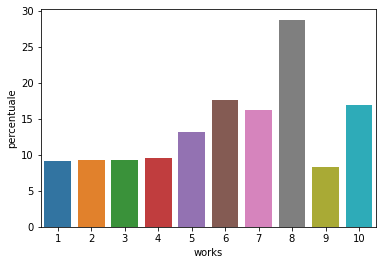

In [54]:
#molto simile al grafico sotto, si tratta della media della percentuale di ogni utente, dei film belli effettuati divisi per numero di lavori
sns.barplot(y="percentuale", x="works",data = dataframe1)

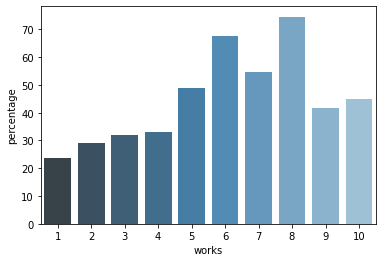

In [50]:
#CON L' AUMENTARE DEL NUMERO DEI LAVORI SI NOTA CHE AUMENTA LA PERCENTUALE DELLE PERSONE CHE HANNO NELLA CARRIERA ALMENO IL 10% DI FILM BELLI
sns.barplot(y="percentage", x="works",data = df_Hyphothesis, palette="Blues_d")

## I  ruoli che impattano di più nel riuscire ad avere un film bello

In [55]:
dataframe

,_id,works,department,movie_id,vote_average,vote_count,bestfilm,numberfilm,percentuale
0,1,6,Directing,11,8.1,6778.0,13,50,26.0
1,1,6,Production,11,8.1,6778.0,13,50,26.0
2,1,6,Writing,11,8.1,6778.0,13,50,26.0
3,1,6,Writing,22588,5.8,12.0,13,50,26.0
4,1,6,Editing,1891,8.2,5998.0,13,50,26.0
...,...,...,...,...,...,...,...,...,...
1026783,1866948,2,Writing,444066,7.3,3.0,0,1,0.0
1026784,1879151,1,Directing,327924,0.0,0.0,0,1,0.0
1026785,1879152,1,Writing,327924,0.0,0.0,0,1,0.0
1026786,1879153,1,Writing,327924,0.0,0.0,0,1,0.0


In [70]:
data_nofilter = dataframe.groupby(['works', 'department']).count()
data_nofilter.reset_index(inplace=True)
data_nofilter =  data_nofilter.rename(columns = {'_id' : 'total'})
data_nofilter = data_nofilter.drop(['movie_id','vote_average','vote_count','bestfilm','numberfilm','percentuale'], axis=1)

In [72]:
filte = dataframe[dataframe['vote_average']> 7.5]
data = filte.groupby(['works', 'department']).count()
data.reset_index(inplace=True)
data =  data.rename(columns = {'_id' : 'count'})
data = data.drop(['movie_id','vote_average','vote_count','bestfilm','numberfilm','percentuale'], axis = 1 ) 

In [73]:
data_nofilter


,works,department,total
0,1,Actor,484867
1,1,Actors,3
2,1,Art,33757
3,1,Camera,20731
4,1,Costume & Make-Up,27229
...,...,...,...
117,10,Editing,20
118,10,Production,29
119,10,Sound,32
120,10,Visual Effects,4


In [74]:
data

,works,department,count
0,1,Actor,34923
1,1,Art,2170
2,1,Camera,1556
3,1,Costume & Make-Up,1856
4,1,Crew,1435
...,...,...,...
97,10,Crew,2
98,10,Directing,7
99,10,Production,1
100,10,Sound,4


In [79]:
df_merge1 = pd.merge(data,data_nofilter, on=['works', 'department'])
df_merge1['percentage'] = (df_merge1['count']/df_merge1['total'])*100 
df_merge1

,works,department,count,total,percentage
0,1,Actor,34923,484867,7.202594
1,1,Art,2170,33757,6.428296
2,1,Camera,1556,20731,7.505668
3,1,Costume & Make-Up,1856,27229,6.816262
4,1,Crew,1435,16787,8.548281
...,...,...,...,...,...
97,10,Crew,2,7,28.571429
98,10,Directing,7,47,14.893617
99,10,Production,1,29,3.448276
100,10,Sound,4,32,12.500000


In [88]:
s = 9

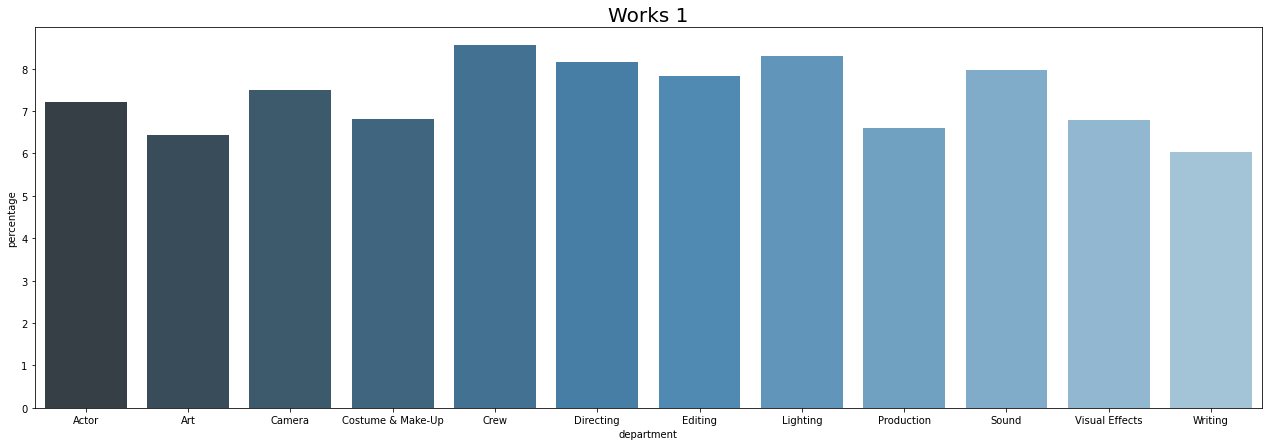

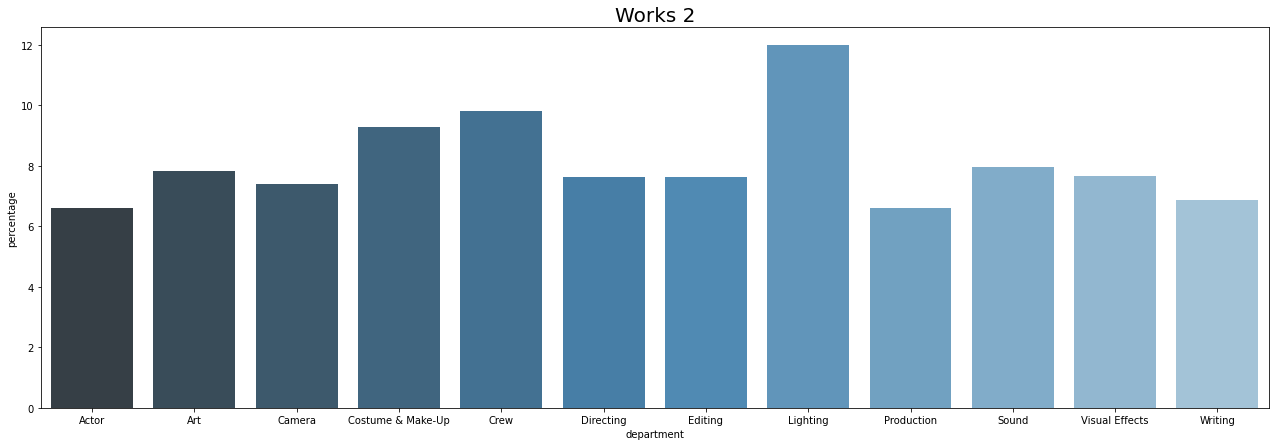

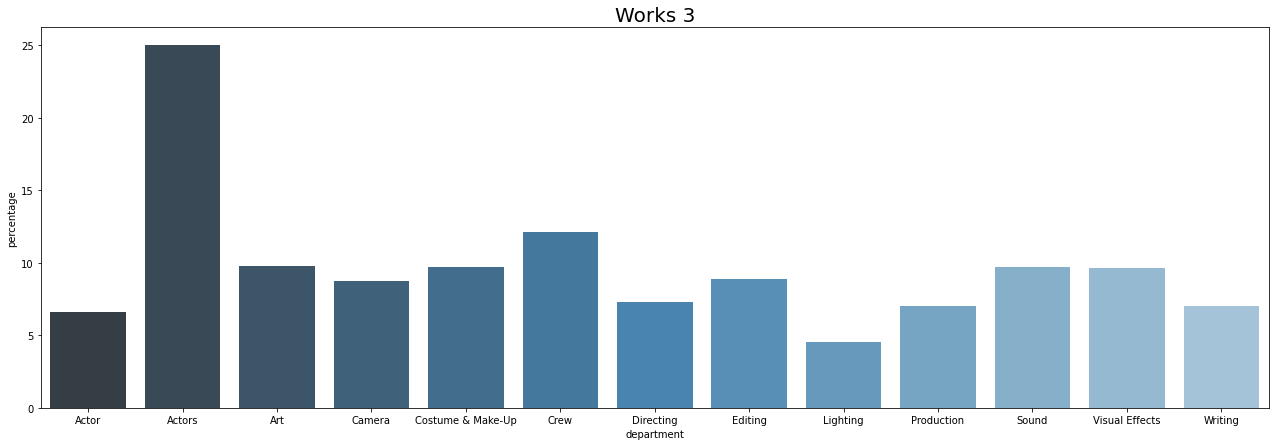

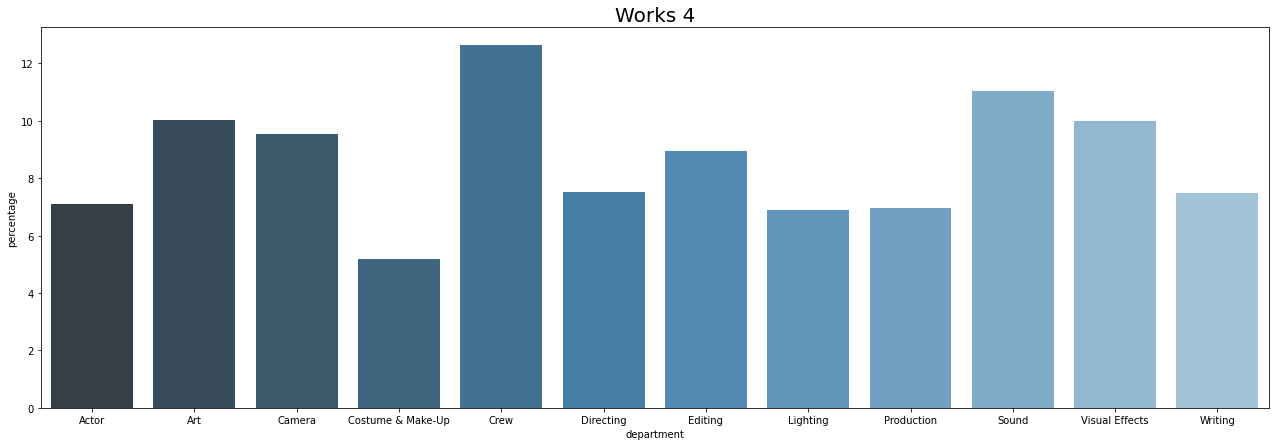

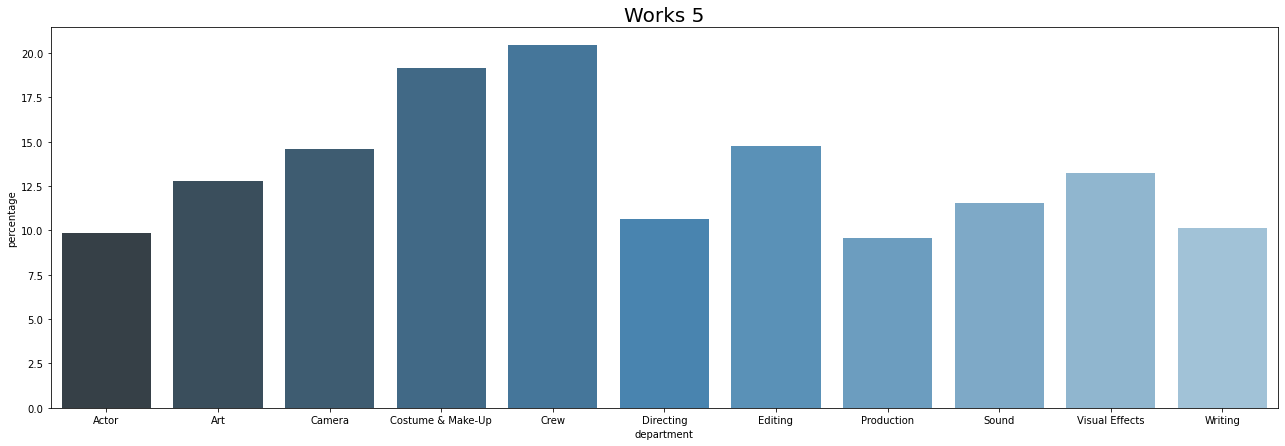

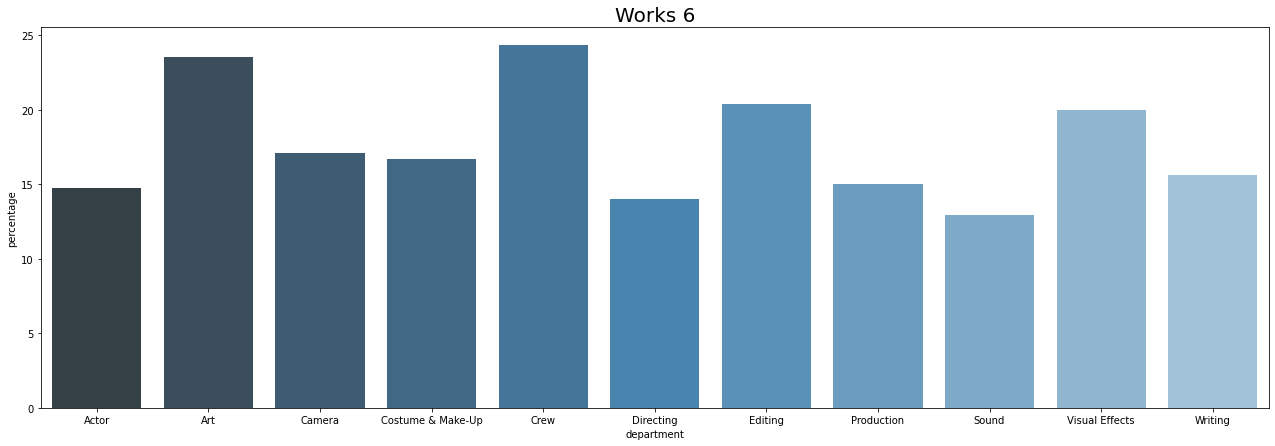

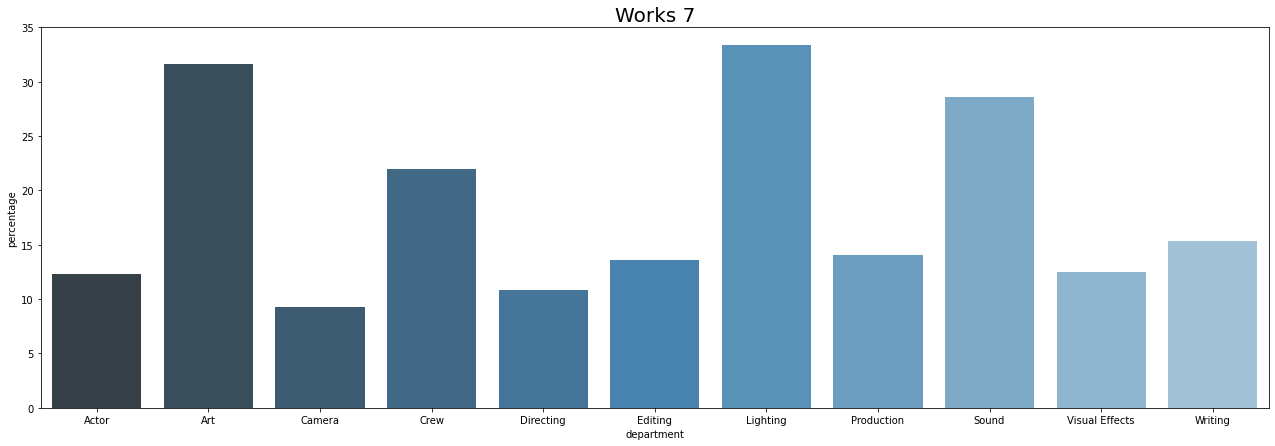

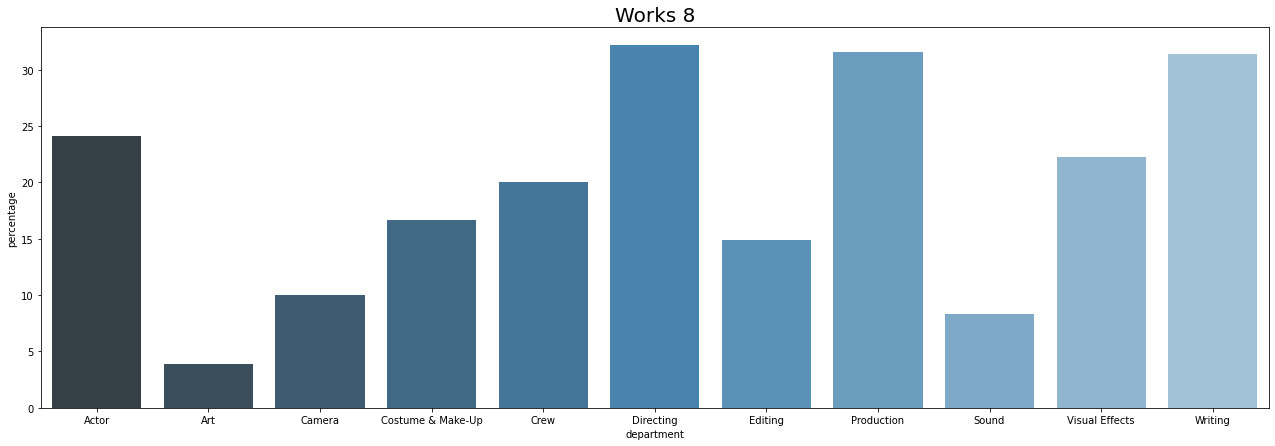

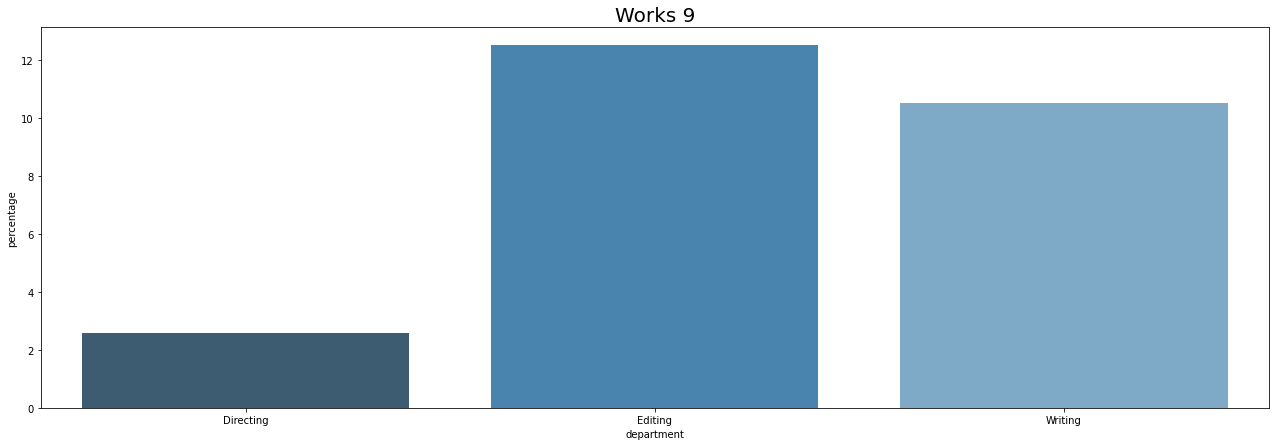

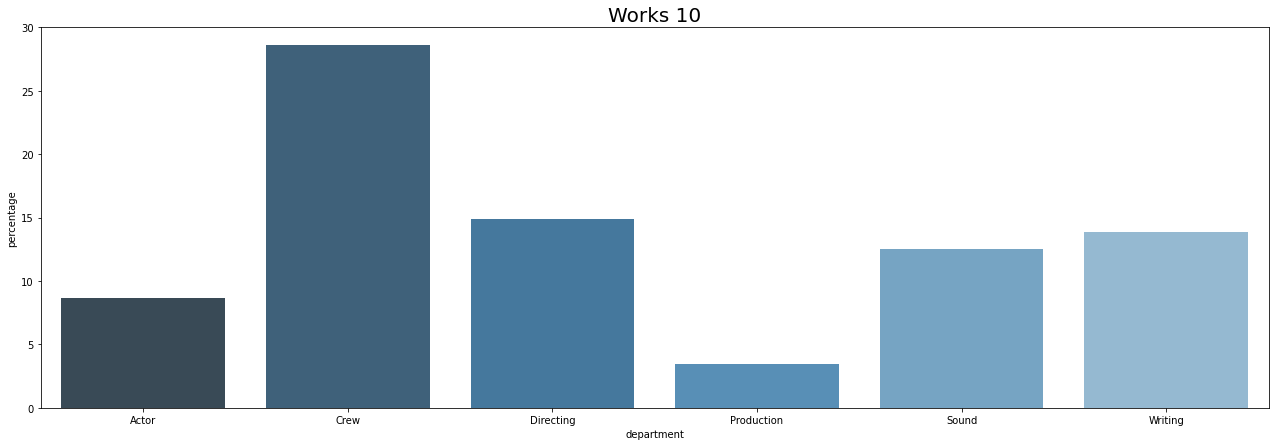

In [95]:
for i in range(10):
    i = i+1
    fig = plt.figure(figsize=(22,7))
    plt.title(f'Works {i}',fontsize=20)
    df_work = df_merge1[df_merge1['works'] == i]  
    sns.barplot(y="percentage", x="department",data = df_work, palette="Blues_d")